# DwC Events. PSZMP data

**Puget Sound Zooplankton Monitoring Program dataset.** Alignment of dataset to Darwin Core (DwC) for NANOOS, https://www.nanoos.org. This data alignment work, including this Jupyter notebook, are described in the GitHub repository https://github.com/nanoos-pnw/obis-pszmp. See [README.md](https://github.com/nanoos-pnw/obis-pszmp/blob/main/README.md).   

Emilio Mayorga, https://github.com/emiliom   

3/25,23,22,19,13,7,5-1. 2/16,15,12,10-9, 1/31/2024

**TODO:**
- Add event `georeferenceRemarks` or `georeferenceProtocol`?
- ~~DONE. Add an event remark column, `eventRemarks`, to store an acknowledgement / statement of the Sampling Group that carried out the sampling (Or is there a DwC Event field that's actually targeted to this need??). Add this to all event types? Use a version of the `common_mappings.json` `cruises` dict where organization names are fully fleshed out.~~
- ~~DONE. Add event `stateProvince` and `footprintSRS`~~

## Goals and scope of this notebook

Parse the source data to define and pull out 3 event "types": `cruise`, `stationVisit` and `sample`. The DwC event table is populated sequentially for each of those event types, in that order, from the most temporally aggregated (cruise) to the most granular (sample). Columns are populated differently depending on the event type. The notebook generates the DwC "event" file `DwC_event.csv`.

## Settings

In [221]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import MultiPoint

from data_preprocess import create_csv_zip, read_and_parse_sourcedata

In [222]:
data_pth = Path(".")

Set to `True` when debugging. `csv` ﬁles will not be exported when `debug_no_csvexport = True`

In [223]:
debug_no_csvexport = False

## Process JSON file containing common mappings and strings

In [224]:
with open(data_pth / 'common_mappings.json') as f:
    mappings = json.load(f)

In [225]:
DatasetCode = mappings['datasetcode']
sampling_groups = mappings['sampling_groups']
# stations = mappings['stations']
net_tow = mappings['net_tow']

iso8601_format = mappings['iso8601_format']
CRS = mappings['CRS']

## Pre-process data for Event table

### Read and pre-processe the source data from Excel file

`usecols` defines the columns that will be kept and the order in which they'll be organized

In [226]:
# Note: I'm including 'Sample Date' and 'Sample Time' just for QA/QC, if needed.
# They won't be used here, since 'time' already captures that information
usecols = [
    'Sample Code', 
    'Station', 'Latitude', 'Longitude', 'Site Name', 'Basin', 'Sampling Group',
    'Sample Date', 'Sample Time', 'Day_Night', 'time',
    'Min Tow Depth (m)', 'Max Tow Depth (m)', 'Station Depth (m)',
    'Mesh Size', 'Tow Type', 
]

# eventsource_df = read_and_parse_sourcedata(test_n_rows=10000)[usecols]
eventsource_df = read_and_parse_sourcedata()[usecols]

# TODO: Rename more columns, if needed
eventsource_df.rename(
    columns={
        'Sample Code':'sample_code',
        'Station':'station',
        'Latitude':'latitude',
        'Longitude':'longitude',
        'Min Tow Depth (m)':'depth_min', 
        'Max Tow Depth (m)':'depth_max', 
        'Mesh Size': 'mesh_size',
    },
    inplace=True
)

In [227]:
len(eventsource_df)

185660

**KEEP A COPY OF THE DATAFRAME WHILE STILL IRONING OUT THIS NOTEBOOK. FOR CONVENIENCE**

In [228]:
eventsource_df_UNMODIFIED = eventsource_df.copy()

In [229]:
# eventsource_df = eventsource_df_UNMODIFIED.copy()

In [230]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical
1,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical
2,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical
3,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical
4,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical


### Remove duplicates

Will return only unique samples, where one row = one sample.

In [231]:
eventsource_df = (
    eventsource_df
    .drop_duplicates()
    .sort_values(by='sample_code')
    .reset_index(drop=True)
)

In [232]:
len(eventsource_df)

3567

### `sample_code` examination

 Sample codes are 14-17 characters long, except for 4 entries that are 12 & 13 characters long.

In [233]:
eventsource_df['sample_code'].str.len().value_counts()

14    1384
17     922
15     860
16     397
12       2
13       2
Name: sample_code, dtype: int64

## Create empty Event dataframe

Records from each event type will be appended to this dataframe, by "type". The type is encoded in the `eventType` column, not in the DwC `type` column, which is not used here explicitly (the type is `Event`).

In [234]:
event_cols_dtypes = np.dtype(
    [
        ('eventID', str),
        ('eventType', str), 
        ('parentEventID', str),
        ('eventDate', str), 
        ('locationID', str),
        ('locality', str),
        ('decimalLatitude', float),
        ('decimalLongitude', float),
        ('geodeticDatum', str),
        ('footprintWKT', str),
        ('footprintSRS', str),
        ('waterBody', str),
        ('countryCode', str), 
        ('stateProvince', str),
        ('minimumDepthInMeters', float),
        ('maximumDepthInMeters', float),
        ('samplingProtocol', str),
        ('eventRemarks', str),
    ]
)

In [235]:
event_df = pd.DataFrame(np.empty(0, dtype=event_cols_dtypes))

## Create cruise events

Use `Sampling Group` as the grouping attribute, analogous to cruises. Set up a dictionary in `mappings.json` matching up the `Sampling Group` strings to fleshed out descriptions and anything else that might be relevant.

- Assign cruise code based on a date string and a sanitized version of `Sampling Group` strings, from `cruises`
- Use `group_by` to generate cruise `time` start and end
- Come up with cruise `eventID`. Come up with a project/dataset code first
- Populating `event_df` with cruise events

Add cruise-related columns to `eventsource_df`. `date_yyyymmdd` will be used to link cruise events to stationVisit events

In [236]:
eventsource_df['date_yyyymmdd'] = eventsource_df['time'].apply(lambda dt: dt.strftime("%Y%m%d"))
eventsource_df['cruise_code'] = (
    eventsource_df['date_yyyymmdd'] + "_" + eventsource_df['Sampling Group'].apply(lambda s: sampling_groups[s][0])
)

In [237]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,Point Jefferson,Central Basin,KC,2022-01-03 00:00:00,08:15:00,D,2022-01-03 08:15:00-08:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:23:00,D,2022-01-04 13:23:00-08:00,38.0,0.0,210.0,335,Oblique,20220104,20220104_KC
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:05:00,D,2022-01-04 13:05:00-08:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,East Passage,Central Basin,KC,2022-01-04 00:00:00,10:49:00,D,2022-01-04 10:49:00-08:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC


### Create cruise footprintWKT and centroid points

Will use `MultiPoint` geometry.

In [238]:
cruise_stations_df = eventsource_df[
    ['cruise_code', 'latitude', 'longitude', 'Basin', 'Sampling Group']
].drop_duplicates()

In [239]:
len(cruise_stations_df)

3007

In [240]:
cruise_stations_df.head(10)

,cruise_code,latitude,longitude,Basin,Sampling Group
0,20180102_LUM,48.63795,-122.5694,Bellingham Bay,LUM
1,20220103_KC,47.74396,-122.4282,Central Basin,KC
2,20220104_KC,47.53333,-122.4333,Central Basin,KC
4,20220104_KC,47.35862,-122.3871,Central Basin,KC
5,20210106_NOAA,48.25673,-122.5442,Whidbey Basin,NOAA
6,20180108_NIT,47.15243,-122.6586,South Sound,NIT
7,20200108_KC,47.74396,-122.4282,Central Basin,KC
9,20200108_KC,47.53333,-122.4333,Central Basin,KC
11,20200108_KC,47.35862,-122.3871,Central Basin,KC
12,20210108_HCSEG_DOE,47.53787,-123.0096,Hood Canal,HCSEG/DOE


In [241]:
cruise_footprints_df = (
    cruise_stations_df
    .groupby(['cruise_code'])[['longitude', 'latitude']]
    .apply(lambda row: MultiPoint(row.values.tolist()))
    .rename('geometry')
    .reset_index(drop=False)
)
cruise_footprints_gdf = gpd.GeoDataFrame(
    cruise_footprints_df, 
    geometry=cruise_footprints_df['geometry'], 
    crs=CRS
)

In [242]:
len(cruise_footprints_gdf)

1333

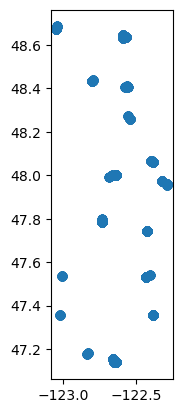

In [243]:
cruise_footprints_gdf.plot();

In [244]:
cruise_footprints_gdf['footprintWKT'] = cruise_footprints_gdf.geometry.to_wkt()
# Add footprint centroid longitude and latitude
cruise_footprints_gdf['decimalLongitude'] = cruise_footprints_gdf.centroid.x.round(3)
cruise_footprints_gdf['decimalLatitude'] = cruise_footprints_gdf.centroid.y.round(3)
cruise_footprints_gdf.reset_index(drop=False, inplace=True)

/tmp/ipykernel_79446/726686464.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cruise_footprints_gdf['decimalLongitude'] = cruise_footprints_gdf.centroid.x.round(3)
/tmp/ipykernel_79446/726686464.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cruise_footprints_gdf['decimalLatitude'] = cruise_footprints_gdf.centroid.y.round(3)


In [245]:
cruise_footprints_gdf.head()

,index,cruise_code,geometry,footprintWKT,decimalLongitude,decimalLatitude
0,0,20140325_NIT,"MULTIPOINT (-122.83180 47.17997, -122.83520 47...","MULTIPOINT (-122.8318 47.17997, -122.8352 47.1...",-122.833,47.179
1,1,20140401_NIT,"MULTIPOINT (-122.63540 47.13843, -122.63770 47...","MULTIPOINT (-122.6354 47.13843, -122.6377 47.1...",-122.642,47.143
2,2,20140404_PGST_WDFW,MULTIPOINT (-122.63600 48.00273),MULTIPOINT (-122.636 48.00273),-122.636,48.003
3,3,20140409_KC,"MULTIPOINT (-122.43330 47.53333, -122.42820 47...","MULTIPOINT (-122.4333 47.53333, -122.4282 47.7...",-122.416,47.545
4,4,20140409_NIT,"MULTIPOINT (-122.63670 47.13892, -122.65860 47...","MULTIPOINT (-122.6367 47.13892, -122.6586 47.1...",-122.738,47.161


In [246]:
# cruise_df = eventsource_df.groupby(['cruise_code', 'date_yyyymmdd', 'Basin']).agg({
cruise_df = eventsource_df.groupby(['cruise_code', 'date_yyyymmdd', 'Sampling Group']).agg({
    'time':['min', 'max'],
    'depth_min':['min', 'max'],
    'depth_max':['min', 'max'],
    'Basin':['first']
})
cruise_df.columns = ["_".join(stat) for stat in cruise_df.columns.ravel()]

cruise_df.head()

/tmp/ipykernel_79446/3364492212.py:8: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  cruise_df.columns = ["_".join(stat) for stat in cruise_df.columns.ravel()]


,,,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin_first
cruise_code,date_yyyymmdd,Sampling Group,,,,,,,
20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,30.0,0.0,40.0,South Sound
20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,30.0,0.0,122.0,South Sound
20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet
20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,30.0,0.0,200.0,Central Basin
20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,30.0,0.0,123.0,South Sound


See comments for depth min & max handling under stationVisit events.

In [247]:
cruise_df["depth_min_final"] = cruise_df[["depth_min_min", "depth_max_min"]].min(axis=1)
cruise_df["depth_max_final"] = cruise_df[["depth_min_max", "depth_max_max"]].max(axis=1)

In [248]:
cruise_df = (
    cruise_df.
    rename(columns={
        'depth_min_final':'minimumDepthInMeters', 
        'depth_max_final':'maximumDepthInMeters',
        'Basin_first': 'Basin',
        })
    .sort_values(by='cruise_code')
    .reset_index(drop=False)
)

**TODO:** In my original implementatoion of `cruise_df`, `cruise_code` values were not unique. Some cruises involve visits to sites in different Basins (eg, '20221219_PGST_WDFW', '20150804_PGST_WDFW'). So, I can't include `Basin` in the creation of `cruise_df`, above. But then I won't be able to enter a useful, granular value into `waterBody`! *For now, I'm using the FIRST occurrence of `Basin` to populate `waterBody`.* It won't be strictly accurate for cruises with >1 `Basin`, but that's only ~ 60 cruises -- a very small percent of the total.

In [249]:
len(cruise_df.cruise_code.unique()) == len(cruise_df)

True

In [250]:
len(cruise_df), len(cruise_df.cruise_code.unique()), len(cruise_footprints_gdf)

(1333, 1333, 1333)

In [251]:
# This form is for populating eventDate with an iso8601 interval
#     lambda row: "{}/{}".format(row['time_min'].strftime(iso8601_format), 
#                                row['time_max'].strftime(iso8601_format)),

cruise_df['eventDate'] = cruise_df.apply(
    lambda row: "{}".format(row['time_min'].strftime(iso8601_format)),
    axis=1
)

In [252]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin,minimumDepthInMeters,maximumDepthInMeters,eventDate
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,30.0,0.0,40.0,South Sound,0.0,40.0,2014-03-25T10:35:00-0700
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,30.0,0.0,122.0,South Sound,0.0,122.0,2014-04-01T10:01:00-0700
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet,0.0,100.0,2014-04-04T13:00:00-0700
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,30.0,0.0,200.0,Central Basin,0.0,200.0,2014-04-09T09:25:00-0700
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,30.0,0.0,123.0,South Sound,0.0,123.0,2014-04-09T10:30:00-0700


In [253]:
cruise_df = cruise_df.merge(cruise_footprints_gdf, on='cruise_code')
len(cruise_df)

1333

In [254]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin,minimumDepthInMeters,maximumDepthInMeters,eventDate,index,geometry,footprintWKT,decimalLongitude,decimalLatitude
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,30.0,0.0,40.0,South Sound,0.0,40.0,2014-03-25T10:35:00-0700,0,"MULTIPOINT (-122.83180 47.17997, -122.83520 47...","MULTIPOINT (-122.8318 47.17997, -122.8352 47.1...",-122.833,47.179
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,30.0,0.0,122.0,South Sound,0.0,122.0,2014-04-01T10:01:00-0700,1,"MULTIPOINT (-122.63540 47.13843, -122.63770 47...","MULTIPOINT (-122.6354 47.13843, -122.6377 47.1...",-122.642,47.143
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet,0.0,100.0,2014-04-04T13:00:00-0700,2,MULTIPOINT (-122.63600 48.00273),MULTIPOINT (-122.636 48.00273),-122.636,48.003
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,30.0,0.0,200.0,Central Basin,0.0,200.0,2014-04-09T09:25:00-0700,3,"MULTIPOINT (-122.43330 47.53333, -122.42820 47...","MULTIPOINT (-122.4333 47.53333, -122.4282 47.7...",-122.416,47.545
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,30.0,0.0,123.0,South Sound,0.0,123.0,2014-04-09T10:30:00-0700,4,"MULTIPOINT (-122.63670 47.13892, -122.65860 47...","MULTIPOINT (-122.6367 47.13892, -122.6586 47.1...",-122.738,47.161


### Create additional attributes

Includes global, constant values

**TODO:** See the questions below for `eventType` and `waterBody`

In [255]:
cruise_df['eventID'] = DatasetCode + "-" + cruise_df['cruise_code']
# Add Puget Sound somewhere in there, or is Salish Sea good enough?
cruise_df['waterBody'] = cruise_df['Basin'] + ', Salish Sea'
cruise_df['eventRemarks'] = "Sample collection by " + cruise_df['Sampling Group'].apply(lambda s: sampling_groups[s][1])

# Should it be something different? Sampling a single station hardly qualifies as a cruise
cruise_df['eventType'] = 'cruise'
cruise_df['geodeticDatum'] = CRS
cruise_df['footprintSRS'] = CRS
cruise_df['countryCode'] = 'US'
cruise_df['stateProvince'] = 'Washington'

In [256]:
cruise_df.head()

,cruise_code,date_yyyymmdd,Sampling Group,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,Basin,...,decimalLongitude,decimalLatitude,eventID,waterBody,eventRemarks,eventType,geodeticDatum,footprintSRS,countryCode,stateProvince
0,20140325_NIT,20140325,NIT,2014-03-25 10:35:00-07:00,2014-03-25 11:47:00-07:00,0.0,30.0,0.0,40.0,South Sound,...,-122.833,47.179,PSZMP-20140325_NIT,"South Sound, Salish Sea",Sample collection by Nisqually Indian Tribe,cruise,EPSG:4326,EPSG:4326,US,Washington
1,20140401_NIT,20140401,NIT,2014-04-01 10:01:00-07:00,2014-04-01 11:50:00-07:00,0.0,30.0,0.0,122.0,South Sound,...,-122.642,47.143,PSZMP-20140401_NIT,"South Sound, Salish Sea",Sample collection by Nisqually Indian Tribe,cruise,EPSG:4326,EPSG:4326,US,Washington
2,20140404_PGST_WDFW,20140404,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,Admiralty Inlet,...,-122.636,48.003,PSZMP-20140404_PGST_WDFW,"Admiralty Inlet, Salish Sea",Sample collection by Port Gamble S’Klallam Tri...,cruise,EPSG:4326,EPSG:4326,US,Washington
3,20140409_KC,20140409,KC,2014-04-09 09:25:00-07:00,2014-04-09 13:33:00-07:00,0.0,30.0,0.0,200.0,Central Basin,...,-122.416,47.545,PSZMP-20140409_KC,"Central Basin, Salish Sea",Sample collection by King County,cruise,EPSG:4326,EPSG:4326,US,Washington
4,20140409_NIT,20140409,NIT,2014-04-09 10:30:00-07:00,2014-04-09 13:41:00-07:00,0.0,30.0,0.0,123.0,South Sound,...,-122.738,47.161,PSZMP-20140409_NIT,"South Sound, Salish Sea",Sample collection by Nisqually Indian Tribe,cruise,EPSG:4326,EPSG:4326,US,Washington


### Populate (append to) the `event_df` table with the cruise events

In [257]:
event_df = pd.concat(
    [
        event_df,
        cruise_df[[
            'eventID', 'eventType', 'eventDate', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'footprintWKT', 'footprintSRS', 
            'waterBody', 'countryCode', 'stateProvince',
            'minimumDepthInMeters', 'maximumDepthInMeters',
            'eventRemarks'
        ]]
    ],
    ignore_index=True
)

In [258]:
event_df.head()

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,geodeticDatum,footprintWKT,footprintSRS,waterBody,countryCode,stateProvince,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,eventRemarks
0,PSZMP-20140325_NIT,cruise,NaN,2014-03-25T10:35:00-0700,NaN,NaN,47.179,-122.833,EPSG:4326,"MULTIPOINT (-122.8318 47.17997, -122.8352 47.1...",EPSG:4326,"South Sound, Salish Sea",US,Washington,0.0,40.0,NaN,Sample collection by Nisqually Indian Tribe
1,PSZMP-20140401_NIT,cruise,NaN,2014-04-01T10:01:00-0700,NaN,NaN,47.143,-122.642,EPSG:4326,"MULTIPOINT (-122.6354 47.13843, -122.6377 47.1...",EPSG:4326,"South Sound, Salish Sea",US,Washington,0.0,122.0,NaN,Sample collection by Nisqually Indian Tribe
2,PSZMP-20140404_PGST_WDFW,cruise,NaN,2014-04-04T13:00:00-0700,NaN,NaN,48.003,-122.636,EPSG:4326,MULTIPOINT (-122.636 48.00273),EPSG:4326,"Admiralty Inlet, Salish Sea",US,Washington,0.0,100.0,NaN,Sample collection by Port Gamble S’Klallam Tri...
3,PSZMP-20140409_KC,cruise,NaN,2014-04-09T09:25:00-0700,NaN,NaN,47.545,-122.416,EPSG:4326,"MULTIPOINT (-122.4333 47.53333, -122.4282 47.7...",EPSG:4326,"Central Basin, Salish Sea",US,Washington,0.0,200.0,NaN,Sample collection by King County
4,PSZMP-20140409_NIT,cruise,NaN,2014-04-09T10:30:00-0700,NaN,NaN,47.161,-122.738,EPSG:4326,"MULTIPOINT (-122.6367 47.13892, -122.6586 47.1...",EPSG:4326,"South Sound, Salish Sea",US,Washington,0.0,123.0,NaN,Sample collection by Nisqually Indian Tribe


## Create stationVisit events

- Use cruise `eventID` from `eventsource_df` as stationVisit `parentEventID`
- Add `stationvisit_code` to `eventsource_df`, for use by the next event type (sample)

In [259]:
# eventsource_df['Sample Code'].str[0:-4].head(10)

`stationvisit_code` will be composed of the date (`date_yyyymmdd`), `Day_Night` and `station`. Assumes a station is not visited (sampled) twice on the same day within the same diurnal period (Day vs Night).

In [260]:
eventsource_df['stationvisit_code'] = (
    # eventsource_df['sample_code'].str[0:-4] + eventsource_df['Day_Night']
    eventsource_df['date_yyyymmdd'] + eventsource_df['Day_Night'] + "_" + eventsource_df['station']
)

In [261]:
eventsource_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code,stationvisit_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM,20180102D_ELIV
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,Point Jefferson,Central Basin,KC,2022-01-03 00:00:00,08:15:00,D,2022-01-03 08:15:00-08:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC,20220103D_KSBP01D
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:23:00,D,2022-01-04 13:23:00-08:00,38.0,0.0,210.0,335,Oblique,20220104,20220104_KC,20220104D_LSNT01D
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:05:00,D,2022-01-04 13:05:00-08:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC,20220104D_LSNT01V
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,East Passage,Central Basin,KC,2022-01-04 00:00:00,10:49:00,D,2022-01-04 10:49:00-08:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC,20220104D_NSEX01V


In [262]:
stationvisit_df = eventsource_df.groupby(
    ['station', 'latitude', 'longitude', 'date_yyyymmdd', 'Day_Night', 'stationvisit_code', 'Basin', 'Site Name', 'Sampling Group']
).agg({
    'time':['min', 'max'],
    'depth_min':['min', 'max'],
    'depth_max':['min', 'max'],
})
stationvisit_df.columns = ["_".join(stat) for stat in stationvisit_df.columns.ravel()]
stationvisit_df = (
    stationvisit_df
    .sort_values(by='time_min')
    .reset_index(drop=False)
)

len(stationvisit_df)

/tmp/ipykernel_79446/3681423359.py:8: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  stationvisit_df.columns = ["_".join(stat) for stat in stationvisit_df.columns.ravel()]


3567

**TODO:**
- 3/4/24: depth issues: Amanda and BethElLee are working on an update to fix some issues
    - ~~DONE. Below, some records have `depth_min_min` > `depth_max_max`! That's non-sensical. It may be due to inconsistent data entry patterns. I may needed to take a different approach: calculate `depth_min_min` as the min and `depth_max_max` as the max of either `depth_min` or `depth_max`~~
    - If both `depth_min_final` and `depth_max_final` are 0.0, should I set them to `np.nan`? Otherwise, having 0.0 values can be misleading.
- ~~DONE. For station `waterBody`, use the stationvisit's own `Basin` value rather than the cruise's `waterBody`. That's to sidestep the issue of cruises that span two Basins, for which I'm only retaining one of them for the cruise.~~

In [263]:
# stationvisit_df.depth_min_min.min(), stationvisit_df.depth_min_min.max(), \
# stationvisit_df.depth_max_max.min(), stationvisit_df.depth_max_max.max()

In [264]:
stationvisit_df["depth_min_final"] = stationvisit_df[["depth_min_min", "depth_max_min"]].min(axis=1)
stationvisit_df["depth_max_final"] = stationvisit_df[["depth_min_max", "depth_max_max"]].max(axis=1)

In [265]:
stationvisit_df.head(10)

,station,latitude,longitude,date_yyyymmdd,Day_Night,stationvisit_code,Basin,Site Name,Sampling Group,time_min,time_max,depth_min_min,depth_min_max,depth_max_min,depth_max_max,depth_min_final,depth_max_final
0,DANAV,47.18327,-122.8307,20140325,D,20140325D_DANAV,South Sound,Dana Passage,NIT,2014-03-25 10:35:00-07:00,2014-03-25 10:35:00-07:00,0.0,0.0,40.0,40.0,0.0,40.0
1,DANAS,47.17593,-122.8355,20140325,D,20140325D_DANAS,South Sound,Dana Passage,NIT,2014-03-25 11:08:00-07:00,2014-03-25 11:08:00-07:00,15.0,15.0,0.0,0.0,0.0,15.0
2,DANAM,47.17678,-122.8352,20140325,D,20140325D_DANAM,South Sound,Dana Passage,NIT,2014-03-25 11:26:00-07:00,2014-03-25 11:26:00-07:00,20.0,20.0,0.0,0.0,0.0,20.0
3,DANAD,47.17997,-122.8318,20140325,D,20140325D_DANAD,South Sound,Dana Passage,NIT,2014-03-25 11:47:00-07:00,2014-03-25 11:47:00-07:00,30.0,30.0,0.0,0.0,0.0,30.0
4,SKETV,47.15243,-122.6586,20140401,D,20140401D_SKETV,South Sound,South Ketron/Solo Point,NIT,2014-04-01 10:01:00-07:00,2014-04-01 10:01:00-07:00,0.0,0.0,122.0,122.0,0.0,122.0
5,SKETS,47.13843,-122.6354,20140401,D,20140401D_SKETS,South Sound,South Ketron/Solo Point,NIT,2014-04-01 10:55:00-07:00,2014-04-01 10:55:00-07:00,10.0,10.0,0.0,0.0,0.0,10.0
6,SKETM,47.13892,-122.6367,20140401,D,20140401D_SKETM,South Sound,South Ketron/Solo Point,NIT,2014-04-01 11:20:00-07:00,2014-04-01 11:20:00-07:00,20.0,20.0,0.0,0.0,0.0,20.0
7,SKETD,47.14032,-122.6377,20140401,D,20140401D_SKETD,South Sound,South Ketron/Solo Point,NIT,2014-04-01 11:50:00-07:00,2014-04-01 11:50:00-07:00,30.0,30.0,0.0,0.0,0.0,30.0
8,ADIV,48.00273,-122.6360,20140404,D,20140404D_ADIV,Admiralty Inlet,Admiralty Inlet,PGST/WDFW,2014-04-04 13:00:00-07:00,2014-04-04 13:00:00-07:00,0.0,0.0,100.0,100.0,0.0,100.0
9,KSBP01V,47.74396,-122.4282,20140409,D,20140409D_KSBP01V,Central Basin,Point Jefferson,KC,2014-04-09 09:25:00-07:00,2014-04-09 09:25:00-07:00,0.0,0.0,200.0,200.0,0.0,200.0


In [266]:
stationvisit_df = stationvisit_df.merge(
    # cruise_df[['date_yyyymmdd', 'eventID', 'waterBody', 'countryCode']],
    cruise_df[
        ['date_yyyymmdd', 'Sampling Group', 'eventID', 'geodeticDatum',
         'countryCode', 'stateProvince', 'eventRemarks']
    ],
    how='left', 
    on=['date_yyyymmdd', 'Sampling Group']
)

In [267]:
len(stationvisit_df)

3567

In [268]:
stationvisit_df.head()

,station,latitude,longitude,date_yyyymmdd,Day_Night,stationvisit_code,Basin,Site Name,Sampling Group,time_min,...,depth_min_max,depth_max_min,depth_max_max,depth_min_final,depth_max_final,eventID,geodeticDatum,countryCode,stateProvince,eventRemarks
0,DANAV,47.18327,-122.8307,20140325,D,20140325D_DANAV,South Sound,Dana Passage,NIT,2014-03-25 10:35:00-07:00,...,0.0,40.0,40.0,0.0,40.0,PSZMP-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe
1,DANAS,47.17593,-122.8355,20140325,D,20140325D_DANAS,South Sound,Dana Passage,NIT,2014-03-25 11:08:00-07:00,...,15.0,0.0,0.0,0.0,15.0,PSZMP-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe
2,DANAM,47.17678,-122.8352,20140325,D,20140325D_DANAM,South Sound,Dana Passage,NIT,2014-03-25 11:26:00-07:00,...,20.0,0.0,0.0,0.0,20.0,PSZMP-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe
3,DANAD,47.17997,-122.8318,20140325,D,20140325D_DANAD,South Sound,Dana Passage,NIT,2014-03-25 11:47:00-07:00,...,30.0,0.0,0.0,0.0,30.0,PSZMP-20140325_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe
4,SKETV,47.15243,-122.6586,20140401,D,20140401D_SKETV,South Sound,South Ketron/Solo Point,NIT,2014-04-01 10:01:00-07:00,...,0.0,122.0,122.0,0.0,122.0,PSZMP-20140401_NIT,EPSG:4326,US,Washington,Sample collection by Nisqually Indian Tribe


In [269]:
stationvisit_df.rename(
    columns={
        'station':'locationID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
        'eventID':'parentEventID',
        'depth_min_final':'minimumDepthInMeters', 
        'depth_max_final':'maximumDepthInMeters',
    },
    inplace=True
)

In [270]:
# This form is for populating eventDate with an iso8601 interval
# stationvisit_df['eventDate'] = stationvisit_df[['time_min', 'time_max']].apply(
#     lambda row: "{}/{}".format(row['time_min'].strftime(iso8601_format), 
#                                row['time_max'].strftime(iso8601_format)),
#     axis=1
# )

stationvisit_df['eventDate'] = stationvisit_df.apply(
    lambda row: "{}".format(row['time_min'].strftime(iso8601_format)),
    axis=1
)

In [271]:
stationvisit_df['eventID'] = DatasetCode + "-" + stationvisit_df['stationvisit_code']
# Using this scheme makes for stationvisit eventID strings that are way too long
# stationvisit_df['eventID'] = stationvisit_df['parentEventID'] + '-' + stationvisit_df['stationvisit_code']
stationvisit_df['waterBody'] = stationvisit_df['Basin'] + ', Salish Sea'
# stationvisit_df['locality'] = stationvisit_df['locationID'].apply(lambda cd: stations[cd])
stationvisit_df['locality'] = stationvisit_df['Site Name']

stationvisit_df['eventType'] = 'stationVisit'

Verify that no duplicate station `eventID` values are created. The `==` statement below should be `True`

In [272]:
len(stationvisit_df.eventID.unique()) == len(stationvisit_df), len(stationvisit_df)

(True, 3567)

In [273]:
stationvisit_df.tail(5)

,locationID,decimalLatitude,decimalLongitude,date_yyyymmdd,Day_Night,stationvisit_code,Basin,Site Name,Sampling Group,time_min,...,parentEventID,geodeticDatum,countryCode,stateProvince,eventRemarks,eventDate,eventID,waterBody,locality,eventType
3562,HCB003V,47.53787,-123.0096,20221214,U,20221214U_HCB003V,Hood Canal,Eldon,HCSEG/DOE,2022-12-14 10:29:00-08:00,...,PSZMP-20221214_HCSEG_DOE,EPSG:4326,US,Washington,Sample collection by Hood Canal Salmon Enhance...,2022-12-14T10:29:00-0800,PSZMP-20221214U_HCB003V,"Hood Canal, Salish Sea",Eldon,stationVisit
3563,HCB004V,47.35620,-123.0249,20221214,U,20221214U_HCB004V,Hood Canal,Sisters Point,HCSEG/DOE,2022-12-14 11:37:00-08:00,...,PSZMP-20221214_HCSEG_DOE,EPSG:4326,US,Washington,Sample collection by Hood Canal Salmon Enhance...,2022-12-14T11:37:00-0800,PSZMP-20221214U_HCB004V,"Hood Canal, Salish Sea",Sisters Point,stationVisit
3564,SARAV,48.25673,-122.5442,20221215,D,20221215D_SARAV,Whidbey Basin,North Saratoga Passage,NOAA/STIL,2022-12-15 11:37:00-08:00,...,PSZMP-20221215_NOAA_STIL,EPSG:4326,US,Washington,Sample collection by NOAA Northwest Fisheries ...,2022-12-15T11:37:00-0800,PSZMP-20221215D_SARAV,"Whidbey Basin, Salish Sea",North Saratoga Passage,stationVisit
3565,ADIV,48.00273,-122.6360,20221219,U,20221219U_ADIV,Admiralty Inlet,Admiralty Inlet,PGST/WDFW,2022-12-19 10:27:00-08:00,...,PSZMP-20221219_PGST_WDFW,EPSG:4326,US,Washington,Sample collection by Port Gamble S’Klallam Tri...,2022-12-19T10:27:00-0800,PSZMP-20221219U_ADIV,"Admiralty Inlet, Salish Sea",Admiralty Inlet,stationVisit
3566,TDBV,47.78297,-122.7330,20221219,D,20221219D_TDBV,Hood Canal,Thorndyke Bay,PGST/WDFW,2022-12-19 11:58:00-08:00,...,PSZMP-20221219_PGST_WDFW,EPSG:4326,US,Washington,Sample collection by Port Gamble S’Klallam Tri...,2022-12-19T11:58:00-0800,PSZMP-20221219D_TDBV,"Hood Canal, Salish Sea",Thorndyke Bay,stationVisit


### Populate (append to) the `event_df` table with the stationVisit events

In [274]:
event_df = pd.concat(
    [
        event_df,
        stationvisit_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'locationID', 'locality', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'waterBody', 'countryCode', 'stateProvince',
            'minimumDepthInMeters', 'maximumDepthInMeters',
            'eventRemarks'
        ]]
    ],
    ignore_index=True
)

len(event_df)

4900

In [275]:
event_df.tail(10)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,geodeticDatum,footprintWKT,footprintSRS,waterBody,countryCode,stateProvince,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,eventRemarks
4890,PSZMP-20221206U_NSEX01V,stationVisit,PSZMP-20221206_KC,2022-12-06T12:36:00-0800,NSEX01V,East Passage,47.35862,-122.3871,EPSG:4326,NaN,NaN,"Central Basin, Salish Sea",US,Washington,0.0,170.0,NaN,Sample collection by King County
4891,PSZMP-20221212U_COW3V2,stationVisit,PSZMP-20221212_KWT,2022-12-12T11:27:00-0800,COW3V2,Cowlitz,48.67437,-123.0481,EPSG:4326,NaN,NaN,"San Juan, Salish Sea",US,Washington,0.0,0.0,NaN,Sample collection by Kwiáht
4892,PSZMP-20221212U_MUKV,stationVisit,PSZMP-20221212_TUL,2022-12-12T11:42:00-0800,MUKV,Mukilteo,47.97166,-122.3222,EPSG:4326,NaN,NaN,"Whidbey Basin, Salish Sea",US,Washington,0.0,200.0,NaN,Sample collection by Tulalip Tribe
4893,PSZMP-20221212U_CAMV,stationVisit,PSZMP-20221212_TUL,2022-12-12T12:31:00-0800,CAMV,Camano Head,48.05901,-122.3873,EPSG:4326,NaN,NaN,"Whidbey Basin, Salish Sea",US,Washington,0.0,175.0,NaN,Sample collection by Tulalip Tribe
4894,PSZMP-20221212U_WAT1V,stationVisit,PSZMP-20221212_KWT,2022-12-12T13:44:00-0800,WAT1V,Watmough Bay,48.43457,-122.8037,EPSG:4326,NaN,NaN,"San Juan, Salish Sea",US,Washington,0.0,30.0,NaN,Sample collection by Kwiáht
4895,PSZMP-20221214U_HCB003V,stationVisit,PSZMP-20221214_HCSEG_DOE,2022-12-14T10:29:00-0800,HCB003V,Eldon,47.53787,-123.0096,EPSG:4326,NaN,NaN,"Hood Canal, Salish Sea",US,Washington,0.0,139.0,NaN,Sample collection by Hood Canal Salmon Enhance...
4896,PSZMP-20221214U_HCB004V,stationVisit,PSZMP-20221214_HCSEG_DOE,2022-12-14T11:37:00-0800,HCB004V,Sisters Point,47.35620,-123.0249,EPSG:4326,NaN,NaN,"Hood Canal, Salish Sea",US,Washington,0.0,48.0,NaN,Sample collection by Hood Canal Salmon Enhance...
4897,PSZMP-20221215D_SARAV,stationVisit,PSZMP-20221215_NOAA_STIL,2022-12-15T11:37:00-0800,SARAV,North Saratoga Passage,48.25673,-122.5442,EPSG:4326,NaN,NaN,"Whidbey Basin, Salish Sea",US,Washington,0.0,85.0,NaN,Sample collection by NOAA Northwest Fisheries ...
4898,PSZMP-20221219U_ADIV,stationVisit,PSZMP-20221219_PGST_WDFW,2022-12-19T10:27:00-0800,ADIV,Admiralty Inlet,48.00273,-122.6360,EPSG:4326,NaN,NaN,"Admiralty Inlet, Salish Sea",US,Washington,0.0,0.0,NaN,Sample collection by Port Gamble S’Klallam Tri...
4899,PSZMP-20221219D_TDBV,stationVisit,PSZMP-20221219_PGST_WDFW,2022-12-19T11:58:00-0800,TDBV,Thorndyke Bay,47.78297,-122.7330,EPSG:4326,NaN,NaN,"Hood Canal, Salish Sea",US,Washington,0.0,115.0,NaN,Sample collection by Port Gamble S’Klallam Tri...


## Create individual "sample" events

Each unique `sample_code` will be an event. `sample_code` will be the eventID, possibly prefixed by the dataset code.

In [276]:
sample_df = eventsource_df.copy()
sample_df.head()

,sample_code,station,latitude,longitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,Day_Night,time,depth_min,depth_max,Station Depth (m),mesh_size,Tow Type,date_yyyymmdd,cruise_code,stationvisit_code
0,010218ELIV1151,ELIV,48.63795,-122.5694,Eliza Island,Bellingham Bay,LUM,2018-01-02 00:00:00,11:51:00,D,2018-01-02 11:51:00-08:00,0.0,110.0,120.7,200,Vertical,20180102,20180102_LUM,20180102D_ELIV
1,010322KSBP01D0815,KSBP01D,47.74396,-122.4282,Point Jefferson,Central Basin,KC,2022-01-03 00:00:00,08:15:00,D,2022-01-03 08:15:00-08:00,22.0,0.0,275.0,335,Oblique,20220103,20220103_KC,20220103D_KSBP01D
2,010422LSNT01D1323,LSNT01D,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:23:00,D,2022-01-04 13:23:00-08:00,38.0,0.0,210.0,335,Oblique,20220104,20220104_KC,20220104D_LSNT01D
3,010422LSNT01V1305,LSNT01V,47.53333,-122.4333,Point Williams,Central Basin,KC,2022-01-04 00:00:00,13:05:00,D,2022-01-04 13:05:00-08:00,0.0,200.0,210.0,200,Vertical,20220104,20220104_KC,20220104D_LSNT01V
4,010422NSEX01V1049,NSEX01V,47.35862,-122.3871,East Passage,Central Basin,KC,2022-01-04 00:00:00,10:49:00,D,2022-01-04 10:49:00-08:00,0.0,170.0,180.0,200,Vertical,20220104,20220104_KC,20220104D_NSEX01V


In [277]:
sample_df = sample_df.merge(
    stationvisit_df[['stationvisit_code', 'eventID',
                     'locationID', 'locality', 'geodeticDatum',
                     'waterBody', 'countryCode', 'stateProvince',
                     'eventRemarks']],
    how='left', 
    on='stationvisit_code'
)

See comments for depth min & max handling under stationVisit events.

In [278]:
sample_df["depth_min_final"] = sample_df[["depth_min", "depth_max"]].min(axis=1)
sample_df["depth_max_final"] = sample_df[["depth_min", "depth_max"]].max(axis=1)

In [279]:
sample_df= (
    sample_df
    .rename(columns={
        'sample_code':'eventID',
        'eventID':'parentEventID',
        'latitude':'decimalLatitude',
        'longitude':'decimalLongitude',
        'depth_min_final':'minimumDepthInMeters',
        'depth_max_final':'maximumDepthInMeters',
    })
    .sort_values(by='time')
    .reset_index(drop=False)
)

In [280]:
# "net_tow": {
#     "Oblique": "depth stratified (oblique)",
#     "Vertical": "full water column"
# },
# two nets: 
# - a 60cm diameter ring net with 200um mesh towed vertically (Vertical)
# - a 60cm bongo net with 335um mesh towed obliquely through the top 30m of the water column (Oblique)
net_type = dict(Vertical="ring", Oblique="bongo")
def samplingProtocol(row):
    return (
        f"{net_tow[row['Tow Type']]} net tow using 60cm diameter"
        f" {net_type[row['Tow Type']]} net,"
        f" {row['mesh_size']} micron mesh"
    )

sample_df['eventDate'] = sample_df['time'].apply(lambda t: t.strftime(iso8601_format))
sample_df['samplingProtocol'] = sample_df.apply(samplingProtocol, axis=1)

sample_df['eventType'] = 'sample'

In [281]:
sample_df.head()

,index,eventID,station,decimalLatitude,decimalLongitude,Site Name,Basin,Sampling Group,Sample Date,Sample Time,...,geodeticDatum,waterBody,countryCode,stateProvince,eventRemarks,minimumDepthInMeters,maximumDepthInMeters,eventDate,samplingProtocol,eventType
0,523,032514DANAV1035,DANAV,47.18327,-122.8307,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,10:35:00,...,EPSG:4326,"South Sound, Salish Sea",US,Washington,Sample collection by Nisqually Indian Tribe,0.0,40.0,2014-03-25T10:35:00-0700,full water column vertical net tow using 60cm ...,sample
1,522,032514DANAS1108,DANAS,47.17593,-122.8355,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,11:08:00,...,EPSG:4326,"South Sound, Salish Sea",US,Washington,Sample collection by Nisqually Indian Tribe,0.0,15.0,2014-03-25T11:08:00-0700,"oblique net tow using 60cm diameter bongo net,...",sample
2,521,032514DANAM1126,DANAM,47.17678,-122.8352,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,11:26:00,...,EPSG:4326,"South Sound, Salish Sea",US,Washington,Sample collection by Nisqually Indian Tribe,0.0,20.0,2014-03-25T11:26:00-0700,"oblique net tow using 60cm diameter bongo net,...",sample
3,520,032514DANAD1147,DANAD,47.17997,-122.8318,Dana Passage,South Sound,NIT,2014-03-25 00:00:00,11:47:00,...,EPSG:4326,"South Sound, Salish Sea",US,Washington,Sample collection by Nisqually Indian Tribe,0.0,30.0,2014-03-25T11:47:00-0700,"oblique net tow using 60cm diameter bongo net,...",sample
4,578,040114sketv1001,SKETV,47.15243,-122.6586,South Ketron/Solo Point,South Sound,NIT,2014-04-01 00:00:00,10:01:00,...,EPSG:4326,"South Sound, Salish Sea",US,Washington,Sample collection by Nisqually Indian Tribe,0.0,122.0,2014-04-01T10:01:00-0700,full water column vertical net tow using 60cm ...,sample


### Populate (append to) the `event_df` table with the sample events

In [282]:
event_df = pd.concat(
    [
        event_df,
        sample_df[[
            'eventID', 'eventType', 'parentEventID', 'eventDate', 
            'locationID', 'locality', 
            'decimalLatitude', 'decimalLongitude', 'geodeticDatum',
            'waterBody', 'countryCode', 'stateProvince',
            'minimumDepthInMeters', 'maximumDepthInMeters', 'samplingProtocol',
            'eventRemarks'
        ]]
    ],
    ignore_index=True
)

len(event_df)

8467

In [283]:
event_df.tail(10)

,eventID,eventType,parentEventID,eventDate,locationID,locality,decimalLatitude,decimalLongitude,geodeticDatum,footprintWKT,footprintSRS,waterBody,countryCode,stateProvince,minimumDepthInMeters,maximumDepthInMeters,samplingProtocol,eventRemarks
8457,120622NSEX01V1236,sample,PSZMP-20221206U_NSEX01V,2022-12-06T12:36:00-0800,NSEX01V,East Passage,47.35862,-122.3871,EPSG:4326,NaN,NaN,"Central Basin, Salish Sea",US,Washington,0.0,170.0,full water column vertical net tow using 60cm ...,Sample collection by King County
8458,121222Cow3V21127,sample,PSZMP-20221212U_COW3V2,2022-12-12T11:27:00-0800,COW3V2,Cowlitz,48.67437,-123.0481,EPSG:4326,NaN,NaN,"San Juan, Salish Sea",US,Washington,0.0,0.0,full water column vertical net tow using 60cm ...,Sample collection by Kwiáht
8459,121222MUKV1142,sample,PSZMP-20221212U_MUKV,2022-12-12T11:42:00-0800,MUKV,Mukilteo,47.97166,-122.3222,EPSG:4326,NaN,NaN,"Whidbey Basin, Salish Sea",US,Washington,0.0,200.0,full water column vertical net tow using 60cm ...,Sample collection by Tulalip Tribe
8460,121222CAMV1231,sample,PSZMP-20221212U_CAMV,2022-12-12T12:31:00-0800,CAMV,Camano Head,48.05901,-122.3873,EPSG:4326,NaN,NaN,"Whidbey Basin, Salish Sea",US,Washington,0.0,175.0,full water column vertical net tow using 60cm ...,Sample collection by Tulalip Tribe
8461,121222Wat1V1344,sample,PSZMP-20221212U_WAT1V,2022-12-12T13:44:00-0800,WAT1V,Watmough Bay,48.43457,-122.8037,EPSG:4326,NaN,NaN,"San Juan, Salish Sea",US,Washington,0.0,30.0,full water column vertical net tow using 60cm ...,Sample collection by Kwiáht
8462,121422HCB003V1029,sample,PSZMP-20221214U_HCB003V,2022-12-14T10:29:00-0800,HCB003V,Eldon,47.53787,-123.0096,EPSG:4326,NaN,NaN,"Hood Canal, Salish Sea",US,Washington,0.0,139.0,full water column vertical net tow using 60cm ...,Sample collection by Hood Canal Salmon Enhance...
8463,121422HCB004V1137,sample,PSZMP-20221214U_HCB004V,2022-12-14T11:37:00-0800,HCB004V,Sisters Point,47.35620,-123.0249,EPSG:4326,NaN,NaN,"Hood Canal, Salish Sea",US,Washington,0.0,48.0,full water column vertical net tow using 60cm ...,Sample collection by Hood Canal Salmon Enhance...
8464,121522SARAV1137,sample,PSZMP-20221215D_SARAV,2022-12-15T11:37:00-0800,SARAV,North Saratoga Passage,48.25673,-122.5442,EPSG:4326,NaN,NaN,"Whidbey Basin, Salish Sea",US,Washington,0.0,85.0,full water column vertical net tow using 60cm ...,Sample collection by NOAA Northwest Fisheries ...
8465,121922ADIV1027,sample,PSZMP-20221219U_ADIV,2022-12-19T10:27:00-0800,ADIV,Admiralty Inlet,48.00273,-122.6360,EPSG:4326,NaN,NaN,"Admiralty Inlet, Salish Sea",US,Washington,0.0,0.0,full water column vertical net tow using 60cm ...,Sample collection by Port Gamble S’Klallam Tri...
8466,121922TDBV1158,sample,PSZMP-20221219D_TDBV,2022-12-19T11:58:00-0800,TDBV,Thorndyke Bay,47.78297,-122.7330,EPSG:4326,NaN,NaN,"Hood Canal, Salish Sea",US,Washington,0.0,115.0,full water column vertical net tow using 60cm ...,Sample collection by Port Gamble S’Klallam Tri...


## Export `event_df` to csv

In [284]:
event_df.eventType.value_counts()

stationVisit    3567
sample          3567
cruise          1333
Name: eventType, dtype: int64

In [285]:
csv_fpth = data_pth / "aligned_csvs" / "DwC_event.csv"

In [286]:
if not debug_no_csvexport:
    event_df.to_csv(csv_fpth, index=False)

### Create zip file with the csv

In [287]:
if not debug_no_csvexport:
    create_csv_zip(csv_fpth)

## Package versions

In [288]:
import datetime

print(
    f"{datetime.datetime.utcnow()} +00:00\n"
    f"pandas: {pd.__version__}, geopandas: {gpd.__version__}"
)

2024-03-26 06:42:08.001140 +00:00
pandas: 1.5.3, geopandas: 0.12.2
